In [1]:
from ThematicTextClassify.TextClassifier import *
from ThematicTextClassify.Preprocessing import *

/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df =pd.read_csv('Categorized_Links.csv')

# Preprocessing Text Function

In [3]:
# add the title and description column together to form a text document
df['Text'] = df['Title']+ df['Description']
df = df.dropna(subset= ['Text'], axis = 0)

# preprocess the newly defined Text column
df['Processed Text'] = df['Text'].map(preprocess_text)
df['processed_string'] =  [' '.join(text) for text in df['Processed Text']]

In [4]:
df['Class'] = ""
df['Class'] = df.apply(lambda df: 'Utilization' if (df['Category'] == 'Utilization') else df['Class'], axis =1)
df['Class'] = df.apply(lambda df: 'Other' if (df['Category'] != 'Utilization') else df['Class'], axis =1)
df = df.reset_index(drop=True)
df = df.sort_values('Class',ascending = False)
df = df.reset_index(drop=True)
df = df.drop_duplicates(['Link'],keep= 'first')
df = df.reset_index(drop=True)
len(df)

301

## Create Training and Test data 

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df,
                                                    df['Class'],
                                                    test_size=0.15, 
                                                    random_state=19)
# 12 19 44 46 47 65 88 96 104 107 111 113 367 370 369 372 373

In [6]:
df['Class'].value_counts()

Other          257
Utilization     44
Name: Class, dtype: int64

In [7]:
class_test.value_counts()

Other          34
Utilization    12
Name: Class, dtype: int64

# Most Frequent words for Utilization

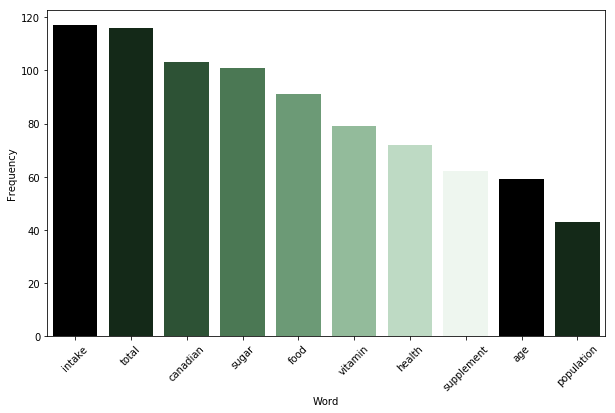

In [9]:
cv = CountVectorizer()
consumption = df[df['Class'] == 'Utilization']['processed_string']
bow_consumption = cv.fit_transform(consumption)
freq_consumption = dict(zip(cv.get_feature_names(), np.asarray(bow_consumption.sum(axis=0)).ravel()))
count_consumption = pd.DataFrame(collections.Counter(freq_consumption).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_consumption, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# General Check on Accuracy using CountVectorizer

/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

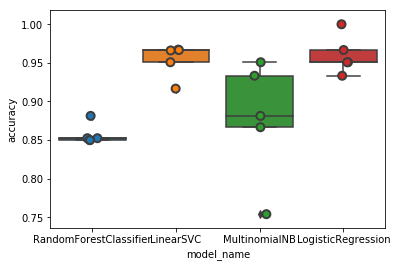

model_name
LinearSVC                 0.953494
LogisticRegression        0.960328
MultinomialNB             0.877255
RandomForestClassifier    0.857255
Name: accuracy, dtype: float64

In [10]:
countvect = CountVectorizer()
features = countvect.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 3000),MultinomialNB(),LogisticRegression(random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# General Check on Accuracy using tfidf

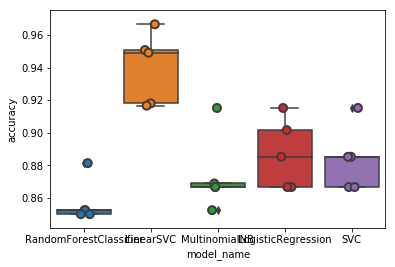

model_name
LinearSVC                 0.940268
LogisticRegression        0.887095
MultinomialNB             0.873980
RandomForestClassifier    0.857255
SVC                       0.883816
Name: accuracy, dtype: float64

In [11]:
tfidf = TfidfVectorizer() 
features = tfidf.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 2000),MultinomialNB(),LogisticRegression(random_state=0), SVC(kernel ='linear', degree = 1, C = 0.25)]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# After comparing the cross validated accuracy of the models suppose we would like to use LinearSVC for our classifier, but we have yet to observe the performance indices and tune parameters

# Multinomial Naive Bayes (CountVectorizer)

In [12]:
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   53.2s finished


done in 53.779s


Best CV score: 0.949
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.870


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.91      0.91      0.91        34
 Utilization       0.75      0.75      0.75        12

    accuracy                           0.87        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.87      0.87      0.87        46

Accuracy Score:  0.8695652173913043


# Multinomial Naive Bayes (TFIDF)

In [13]:
mnb_countvect = grid_vect(mnb, param_mnb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=tfidf)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   48.4s finished


done in 48.459s


Best CV score: 0.965
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.891


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.87      1.00      0.93        34
 Utilization       1.00      0.58      0.74        12

    accuracy                           0.89        46
   macro avg       0.94      0.79      0.83        46
weighted avg       0.91      0.89      0.88        46

Accuracy Score:  0.8913043478260869


# Logistic Regression (CountVectorizer)

In [14]:
logreg_countvect = grid_vect(logreg, param_logreg, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.6min finished


done in 96.262s


Best CV score: 0.961
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.891


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.89      0.97      0.93        34
 Utilization       0.89      0.67      0.76        12

    accuracy                           0.89        46
   macro avg       0.89      0.82      0.85        46
weighted avg       0.89      0.89      0.89        46

Accuracy Score:  0.8913043478260869


# Logisitc Regression (TFIDF)


In [15]:
logreg_tfidf = grid_vect(logreg, param_logreg, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=tfidf)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.7min finished


done in 101.278s


Best CV score: 0.914
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.761


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.77      0.97      0.86        34
 Utilization       0.67      0.17      0.27        12

    accuracy                           0.76        46
   macro avg       0.72      0.57      0.56        46
weighted avg       0.74      0.76      0.70        46

Accuracy Score:  0.7608695652173914


# Linear SVC (CountVectorizer)

In [16]:
linsvc = LinearSVC() 
lscv_countvect = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect= countvect)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  3.3min finished


done in 195.721s


Best CV score: 0.957
Best parameters set:
	clf__C: 0.05
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.891


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.89      0.97      0.93        34
 Utilization       0.89      0.67      0.76        12

    accuracy                           0.89        46
   macro avg       0.89      0.82      0.85        46
weighted avg       0.89      0.89      0.89        46

Accuracy Score:  0.8913043478260869


# Linear SVC (TFIDF)

In [17]:
linsvc = LinearSVC() 
lscv_tfidf = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=tfidf)




Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 121.8min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 122.3min finished


done in 7335.313s


Best CV score: 0.937
Best parameters set:
	clf__C: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.891


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.87      1.00      0.93        34
 Utilization       1.00      0.58      0.74        12

    accuracy                           0.89        46
   macro avg       0.94      0.79      0.83        46
weighted avg       0.91      0.89      0.88        46

Accuracy Score:  0.8913043478260869


# Random Forest Classifier (CountVectorizer)

In [19]:
RandF = RandomForestClassifier()
Randomforest_countvect = grid_vect(RandF, param_RandF, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 19.7min finished


done in 1184.713s


Best CV score: 0.910
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 200
	clf__random_state: 1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.761


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.76      1.00      0.86        34
 Utilization       1.00      0.08      0.15        12

    accuracy                           0.76        46
   macro avg       0.88      0.54      0.51        46
weighted avg       0.82      0.76      0.68        46

Accuracy Score:  0.7608695652173914


# Random Forest Classifier (TFIDF)

In [20]:
Randomforest_tfidf = grid_vect(RandF, param_RandF, text_train,class_train, text_test,class_test, parameters_text=param_vect_countvect, vect=tfidf)


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 11.1min finished


done in 664.595s


Best CV score: 0.906
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 300
	clf__random_state: 1
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.826


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.81      1.00      0.89        34
 Utilization       1.00      0.33      0.50        12

    accuracy                           0.83        46
   macro avg       0.90      0.67      0.70        46
weighted avg       0.86      0.83      0.79        46

Accuracy Score:  0.8260869565217391


# XGBoost (CountVectorizer)

In [9]:
countvect = CountVectorizer()
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_tfidf = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 29.8min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: Deprecation

done in 1789.152s


Best CV score: 0.925
Best parameters set:
	clf__max_depth: 4
	clf__seed: 1
	clf__subsample: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.848


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.83      1.00      0.91        34
 Utilization       1.00      0.42      0.59        12

    accuracy                           0.85        46
   macro avg       0.91      0.71      0.75        46
weighted avg       0.87      0.85      0.82        46

Accuracy Score:  0.8478260869565217


# XGBoost (CountVectorizer)

In [10]:
tfidf = TfidfVectorizer() 
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_countvect = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 30.3min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: Deprecation

done in 1817.326s


Best CV score: 0.925
Best parameters set:
	clf__max_depth: 4
	clf__seed: 1
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.935


Classification Report Test Data


              precision    recall  f1-score   support

       Other       0.92      1.00      0.96        34
 Utilization       1.00      0.75      0.86        12

    accuracy                           0.93        46
   macro avg       0.96      0.88      0.91        46
weighted avg       0.94      0.93      0.93        46

Accuracy Score:  0.9347826086956522
